In [1]:
modelName = 'vgg16_bn-32'
filterName = 'normalize'

point = 'Point1'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os, sys

sys.path.append('../add/')

from vgg import Custom_VGG

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)


weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=300, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=150, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.06313694412090692 | Val loss: 0.0476724962216048
Epoch: 2 / 15 | Train loss: 0.04121366006333426 | Val loss: 0.024114077156853108
Epoch: 3 / 15 | Train loss: 0.01345428803666349 | Val loss: 0.007180753053121623
Epoch: 4 / 15 | Train loss: 0.006849092386483428 | Val loss: 0.005214182560199073
Epoch: 5 / 15 | Train loss: 0.004974372335008334 | Val loss: 0.006116619838091235
Epoch: 6 / 15 | Train loss: 0.00410736192870571 | Val loss: 0.0045186688955817815
Epoch: 7 / 15 | Train loss: 0.003460909075493621 | Val loss: 0.00410581990477762
Epoch: 8 / 15 | Train loss: 0.002611103401195359 | Val loss: 0.004398691066030767
Epoch: 9 / 15 | Train loss: 0.0027715054453569406 | Val loss: 0.0035276446322400476
Epoch: 10 / 15 | Train loss: 0.0027504132896471007 | Val loss: 0.003364356108553087
Epoch: 11 / 15 | Train loss: 0.0019561749739580823 | Val loss: 0.003457458504791638
Epoch: 12 / 15 | Train loss: 0.0023444592872079104 | Val loss: 0.00325733760213812
Epoch: 13 / 15 

11


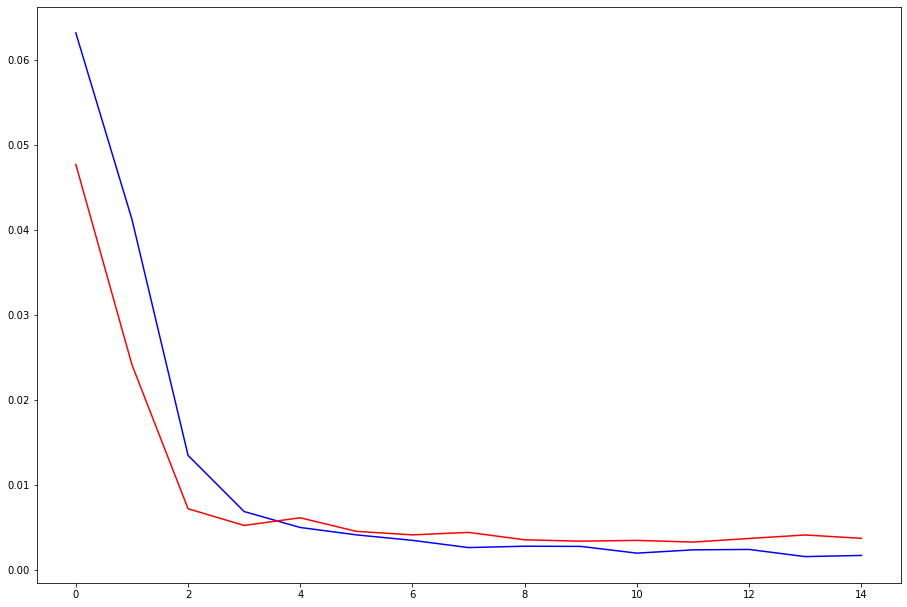

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=200, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 4min 36s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename        model     filter   point  \
0       57554f24-910e-4b74-bc68-9ea75ee7aadb  vgg16_bn-32  normalize  Point1   
1       42c603c0-2957-40d4-b520-b68bd3fa5b05  vgg16_bn-32  normalize  Point1   
2       4d226974-afb2-4ea0-a39e-262df808a8f8  vgg16_bn-32  normalize  Point1   
3       418c81dd-f7f0-420e-9872-3f84118a59ff  vgg16_bn-32  normalize  Point1   
4       5a2b8fff-364d-44db-b353-0625a94200f4  vgg16_bn-32  normalize  Point1   
...                                      ...          ...        ...     ...   
528315  ebdfcc1f-cc06-4322-8d03-498b31e549f4  vgg16_bn-32  normalize  Point1   
528316  3bf851e7-63c0-4132-acc5-639f2da780ac  vgg16_bn-32  normalize  Point1   
528317  25b05fe8-d622-494c-9bf3-874dc3717d1f  vgg16_bn-32  normalize  Point1   
528318  f19de3e7-6ddd-421e-814d-969e5325af65  vgg16_bn-32  normalize  Point1   
528319  307bba44-0fac-414f-ac05-d984bf9e39df  vgg16_bn-32  normalize  Point1   

        v       predict  sign  
0       0  4.708887e-07  -1.0  
1       0  9.986317e-01   1.0  
2       0  1.281100e-07  -1.0  
3       0  1.598576e-06  -1.0  
4       0  3.037052e-06  -1.0  
...    ..           ...   ...  
528315  3  1.506713e-07  -1.0  
528316  3  7.874193e-08  -1.0  
528317  3  4.180363e-09   0.0  
528318  3  2.816212e-07  -1.0  
528319  3  5.224413e-09   0.0  

[528320 rows x 7 columns]

In [17]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)

In [18]:
modelName = 'vgg16_bn-32'
filterName = 'normalize'
point = 'Point2'

pointLoad = 'Point1'

In [19]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{pointLoad}.pt'))

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

In [20]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=300, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=150, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.0016990747465471547 | Val loss: 0.0032766119390241024
Epoch: 2 / 15 | Train loss: 0.0013735816807518377 | Val loss: 0.003129820573598235
Epoch: 3 / 15 | Train loss: 0.0013715590360674009 | Val loss: 0.003172693680902566
Epoch: 4 / 15 | Train loss: 0.0014665571088041459 | Val loss: 0.0031044617545766024
Epoch: 5 / 15 | Train loss: 0.0012649916041767258 | Val loss: 0.0030957074122852646
Epoch: 6 / 15 | Train loss: 0.0015964011796006754 | Val loss: 0.0030002172383579557
Epoch: 7 / 15 | Train loss: 0.0015578403753713783 | Val loss: 0.0029717094248986713
Epoch: 8 / 15 | Train loss: 0.0012983433095421306 | Val loss: 0.0030507483007524917
Epoch: 9 / 15 | Train loss: 0.0012077845656523391 | Val loss: 0.002952562922257043
Epoch: 10 / 15 | Train loss: 0.001100254345037245 | Val loss: 0.003030561619934382
Epoch: 11 / 15 | Train loss: 0.0009922338221839304 | Val loss: 0.0029835131333259468
Epoch: 12 / 15 | Train loss: 0.000877960167522963 | Val loss: 0.002952195742268

12


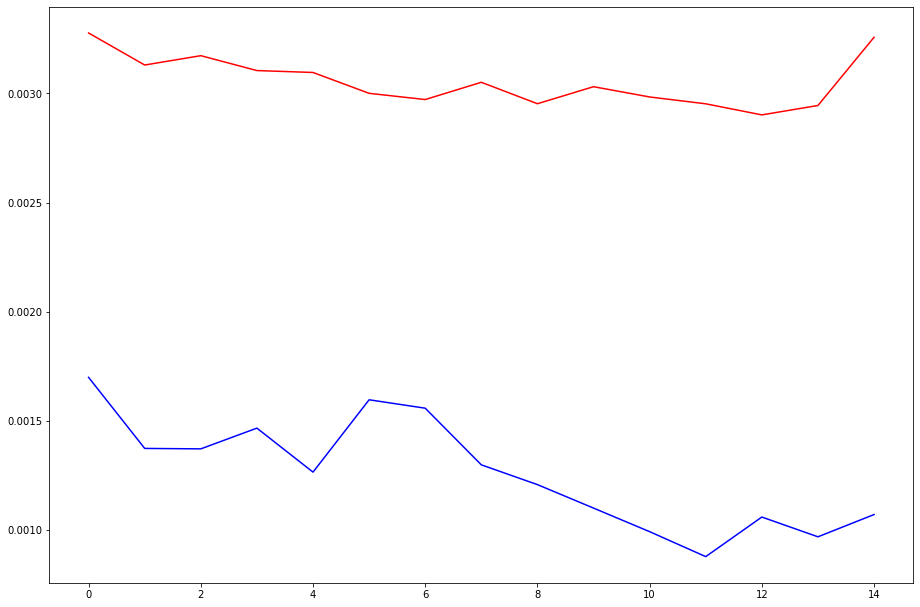

In [21]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [22]:
model = Custom_VGG(pretrained=True, vgg_type='vgg16_bn', ipt_size=(32, 32), num_classes=1)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

<All keys matched successfully>

In [23]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=200, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 4min 41s


In [24]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [25]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename        model     filter   point  \
0       caa0262d-64de-47f4-a8a0-60dda6fa69c1  vgg16_bn-32  normalize  Point2   
1       81caf1ad-7ca9-4ab5-9eff-24bc3cbade90  vgg16_bn-32  normalize  Point2   
2       e8e20946-bb7d-4541-b321-cea3de3d7bf6  vgg16_bn-32  normalize  Point2   
3       8cbd2709-413f-4081-bcac-568d3541da66  vgg16_bn-32  normalize  Point2   
4       e8e100e1-b1be-4e81-a9e6-ae93e9795e50  vgg16_bn-32  normalize  Point2   
...                                      ...          ...        ...     ...   
528315  2ef7033b-78d6-4d7e-a3f0-e97834527c58  vgg16_bn-32  normalize  Point2   
528316  03c846ab-3370-4ade-959f-5429314613c5  vgg16_bn-32  normalize  Point2   
528317  8d449563-65a3-48a0-b373-e59061a99402  vgg16_bn-32  normalize  Point2   
528318  063256c2-534c-4ee2-a370-1162ab6be17f  vgg16_bn-32  normalize  Point2   
528319  987b40a3-fb26-495b-99ae-6142b6133734  vgg16_bn-32  normalize  Point2   

        v       predict  sign  
0       0  5.121246e-08  -1.0  
1       0  5.891637e-09  -1.0  
2       0  7.850342e-10  -1.0  
3       0  2.699924e-14   0.0  
4       0  9.986236e-09  -1.0  
...    ..           ...   ...  
528315  3  4.327807e-08  -1.0  
528316  3  4.167842e-08  -1.0  
528317  3  4.393076e-08  -1.0  
528318  3  9.516981e-09  -1.0  
528319  3  1.156891e-09  -1.0  

[528320 rows x 7 columns]

In [26]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)